# Example 1: Sorting

This is a notebook demonstrating how to use Cython and [stdpar](https://developer.nvidia.com/blog/accelerating-standard-c-with-gpus-using-stdpar/) to accelerate Python code.

This example is centered on a simple task: sorting a sequence of integers

## Setup <a name="setup"></a>

Some essential imports and utility functions for benchmarking:

In [1]:
import timeit

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils import format_time

In [2]:
plt.rcParams.update({'font.size': 15})

In [3]:
def random_data(size):
    return np.random.randint(size, size=size, dtype="int32")

In [4]:
def time_sort(size, sort_func):
    repeat = 10
    dt = 0
    for i in range(repeat):
        data = random_data(size)
        start = timeit.default_timer()
        sort_func(data)
        end = timeit.default_timer()
        dt += (end - start)
    return (dt) / repeat

In [5]:
def run_benchmark(sort_func, name):
    sizes = [100, 1_000, 10_000, 100_000, 1_000_000, 10_000_000]
    return pd.Series(
        [time_sort(s, sort_func) for s in sizes],
        index=sizes,
        name=name
    )

## Calling `std::sort` from Cython

In `cppsort_serial.pyx` below, we define a function `cppsort` that uses the C++ `std::sort` function to sort an input array:

In [6]:
%%writefile cppsort_serial.pyx

# distutils: language=c++

from libcpp.algorithm cimport sort

def cppsort(int[:] x):
    sort(&x[0], &x[-1] + 1) 

Writing cppsort_serial.pyx


To use the `cppsort` function from Python, we need to first build it into an extension module. The following command does just that. The `%%capture` line supresses the output of this command. Uncomment this line and re-run the cell to view the output of the command or to debug any issues.

In [7]:
%%capture
!python setup.py build_ext --inplace

The following code times the execution of `cppsort` for various input sizes, and prints the results:

In [8]:
from cppsort_serial import cppsort

cpu_serial = run_benchmark(cppsort, "CPU serial")
cpu_serial.map(format_time).to_frame()

,CPU serial
100,9.58731397986412 µs
1000,83.82052183151247 µs
10000,899.8926728963853 µs
100000,5.493083223700523 ms
1000000,63.657316379249096 ms
10000000,738.5903754271567 ms


## Parallelizing `std::sort` using CPU threads

We extend the `cppsort` function above by passing the [parallel execution policy](https://en.cppreference.com/w/cpp/algorithm/execution_policy_tag_t) to `std::sort`. For this to work correctly, we must link the [tbb](https://github.com/oneapi-src/oneTBB) library, which provides a parallel implementation of `std::sort`.

In [9]:
%%writefile cppsort_parallel.pyx

# distutils: language=c++
# distutils: libraries=tbb

from libcpp.algorithm cimport sort
from libcpp.execution cimport par

def cppsort(int[:] x):
    sort(par, &x[0], &x[-1] + 1)

Writing cppsort_parallel.pyx


In [10]:
%%capture
!python setup.py build_ext --inplace

In [11]:
from cppsort_parallel import cppsort

cpu_parallel = run_benchmark(cppsort, "CPU parallel")
cpu_parallel.map(format_time).to_frame()

,CPU parallel
100,294.48606073856354 µs
1000,129.76303696632385 µs
10000,300.64815655350685 µs
100000,1.3915035873651505 ms
1000000,11.24824732542038 ms
10000000,133.4529777057469 ms


## `std::sort` on the GPU using stdpar

Finally, `cppsort_stdpar` below is compiled with `nvc++` and the [stdpar](https://developer.nvidia.com/blog/accelerating-standard-c-with-gpus-using-stdpar/) option. This will offload execution to the GPU.

Also note that the input is copied to a (temporary) local buffer and back. This is required because `-stdpar` does not work with externally allocated memory.

In [12]:
%%writefile cppsort_stdpar.pyx

# distutils: language=c++

from libcpp.algorithm cimport sort, copy_n
from libcpp.execution cimport par
from libcpp.vector cimport vector

def cppsort(int[:] x):
    """
    Sort the elements of x "in-place" using std::sort
    """
    cdef vector[int] vec
    vec.resize(len(x))
    copy_n(&x[0], len(x), vec.begin())
    sort(par, vec.begin(), vec.end())
    copy_n(vec.begin(), len(x), &x[0])

Writing cppsort_stdpar.pyx


In [13]:
%%capture
!CC=nvc++ python setup.py build_ext --inplace

In [14]:
from cppsort_stdpar import cppsort

gpu_stdpar = run_benchmark(cppsort, "GPU (nvc++ with -stdpar)")
gpu_stdpar.map(format_time).to_frame()

,GPU (nvc++ with -stdpar)
100,15.209756046533583 ms
1000,498.46600741148 µs
10000,1.2759095057845113 ms
100000,1.9342169165611267 ms
1000000,3.7685805931687355 ms
10000000,33.24034931138158 ms


## Comparing performance

Finally, we plot the speedups over a baseline implementation (NumPy's `.sort()` method):

In [15]:
baseline = run_benchmark(lambda x: x.sort(), "NumPy")

In [16]:
all_timings = pd.DataFrame([baseline, cpu_serial, cpu_parallel, gpu_stdpar]).T
speedups = (1/all_timings).multiply(baseline, axis=0)

In [17]:
all_timings.applymap(format_time)

,NumPy,CPU serial,CPU parallel,GPU (nvc++ with -stdpar)
100,24.51185137033463 µs,9.58731397986412 µs,294.48606073856354 µs,15.209756046533583 ms
1000,32.63205289840698 µs,83.82052183151247 µs,129.76303696632385 µs,498.46600741148 µs
10000,420.42592540383345 µs,899.8926728963853 µs,300.64815655350685 µs,1.2759095057845113 ms
100000,5.270833149552345 ms,5.493083223700523 ms,1.3915035873651505 ms,1.9342169165611267 ms
1000000,62.6989365555346 ms,63.657316379249096 ms,11.24824732542038 ms,3.7685805931687355 ms
10000000,734.8604965023696 ms,738.5903754271567 ms,133.4529777057469 ms,33.24034931138158 ms


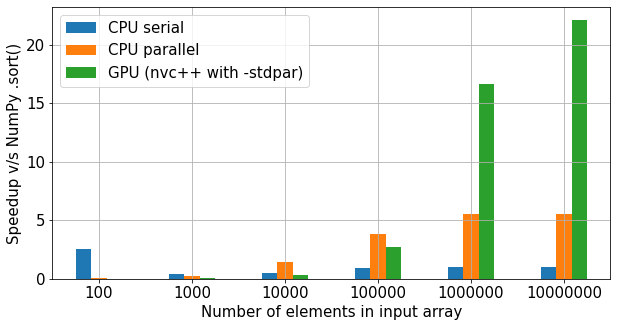

In [18]:
speedups.iloc[:, 1:].plot(
    kind="bar", 
    xlabel="Number of elements in input array", 
    ylabel="Speedup v/s NumPy .sort()", 
    figsize=(10, 5),
    grid=True
)
plt.xticks(rotation=0)
plt.savefig("sort.png")